In [1]:
import warnings

warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind, wilcoxon, ranksums,ttest_1samp
from scipy.signal import find_peaks

from nilearn.image import load_img, new_img_like
from nilearn.plotting import plot_img_on_surf

from scipy.spatial.distance import cdist
import rle
import awkward as ak


In [2]:
maxrois = pd.read_csv('/home/joyneelm/emoprox2_slds_bootstrap_resamples/README_MAX_ROIs_final_gm_85.txt',sep='\t')

In [3]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
# subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [4]:
K = 6
D = 10
N = 85
num_subjs = 92
M=20
num_resamples = 500

In [5]:
with open(f'pkl/all_dfs_models_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    all_dfs,all_models = pickle.load(f)

In [6]:
with open(f'pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    state_masks = pickle.load(f)

In [7]:
print(len(all_dfs),len(all_models),len(state_masks))

500 500 500


In [8]:
    # Ahat_columnnorm_shuffled = Ahat_columnnorm.copy()
    # Ahat_columnnorm_shuffled = Ahat_columnnorm_shuffled[:,np.random.permutation(N)]

    # df['roi_importance'] = [None]*df.shape[0]
    # df['null_roi_importance'] = [None]*df.shape[0]
    # for idx_row,row in df.iterrows():
    #     y = row['timeseries']
    #     z = row['discrete_states']

    #     df.at[idx_row,'roi_importance'] = np.multiply(abs(y),Ahat_columnnorm[z,:])
    #     df.at[idx_row,'null_roi_importance'] = np.multiply(abs(y),Ahat_columnnorm_shuffled[z,:])

In [9]:
state_resps = {k:[] for k in range(K)}
for idx_resample in tqdm(range(1,101)):
    df = all_dfs[idx_resample]
    state_mask = state_masks[idx_resample]
    for idx_row,row in df.iterrows():
        y = row['timeseries'].copy()
        
        z = row['discrete_states'].copy()
        states,durations = rle.encode(z)
        onsets = np.cumsum(np.concatenate((np.zeros(1),durations)))[:-1].astype('int')
        for state,onset,duration in zip(states,onsets,durations):
            if state_mask[state]==1: continue
            state_resps[state].append(y[onset:onset+duration,:])


100%|██████████| 100/100 [00:12<00:00,  7.77it/s]


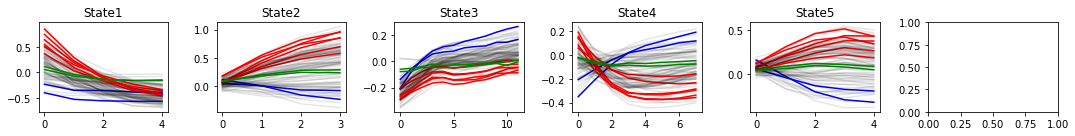

In [10]:
fig,axs = plt.subplots(1,K, figsize=(15,2))
for idx_state in range(K-1):
    dur = int(np.median([y.shape[0] for y in state_resps[idx_state]]))
    mean_resps = ak.to_numpy(ak.mean(ak.Array(state_resps[idx_state]),axis=0))[:dur,:]
    
    ax = axs[idx_state]
    for idx,row in maxrois.iterrows():
        roi = row['Hemi']+' '+row['ROI']
        idx_roi = row['Index']-1
        if "Insula" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker=None,color='r',alpha=1)
        elif  "vmPFC" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker=None,color='b',alpha=1)
        elif  "PAG" in roi:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker=None,color='g',alpha=1)
        else:
            _ = ax.plot(mean_resps[:,idx_roi],label=roi,marker=None,color='k',alpha=0.1)
            
    ax.set_title(f'State{idx_state+1}')

fig.tight_layout()

In [10]:
def vec2img(vec:np.ndarray):
    atlasimg = load_img('/home/joyneelm/templates/MAX_ROIs_final_gm_85.nii.gz')
    atlasdata = atlasimg.get_fdata()
    nrois = vec.shape[0]
    retdata = np.zeros_like(atlasdata)
    for idx_roi in range(nrois):
        retdata[atlasdata==(idx_roi+1)] = vec[idx_roi]
    ret = new_img_like(ref_niimg=atlasimg,data=retdata)
    return ret

(5, 85)
(4, 85)
(12, 85)
(8, 85)
(5, 85)


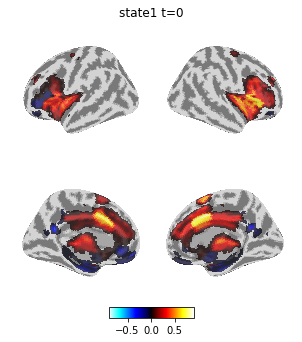

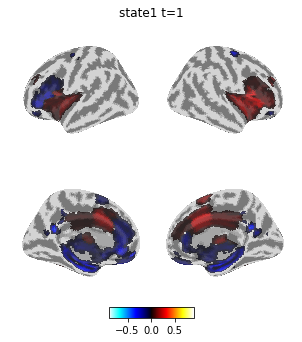

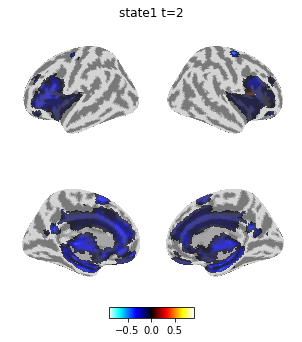

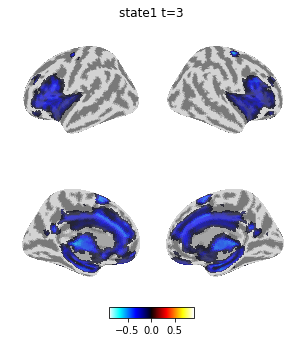

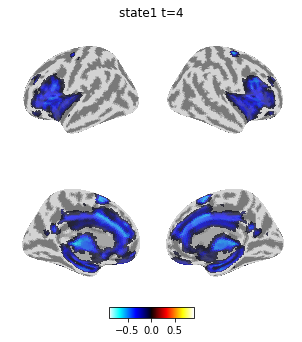

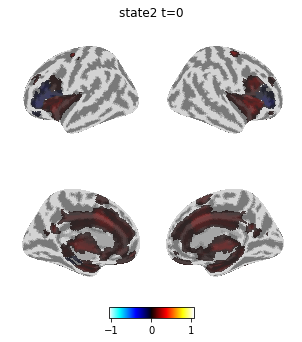

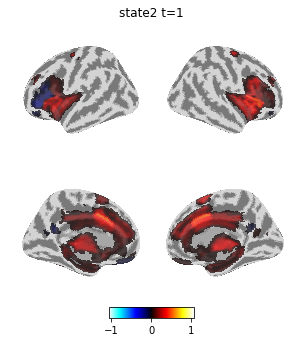

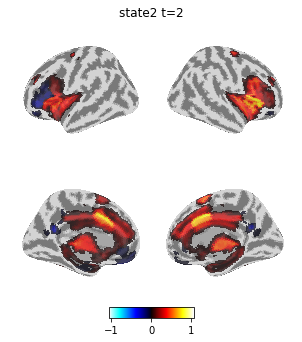

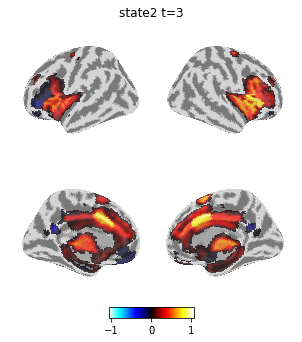

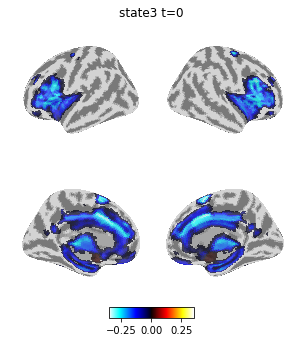

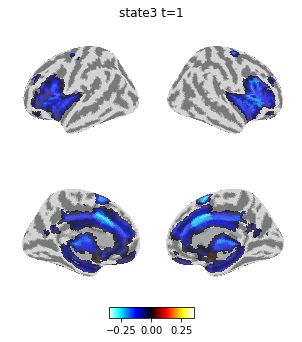

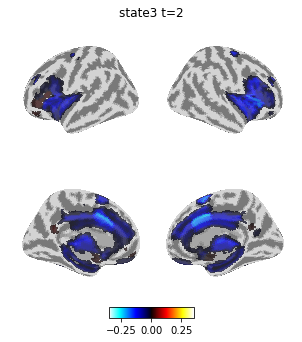

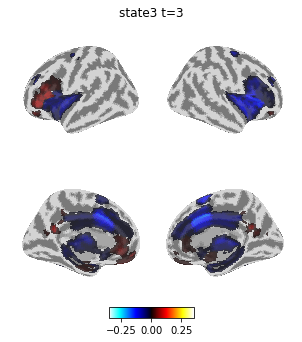

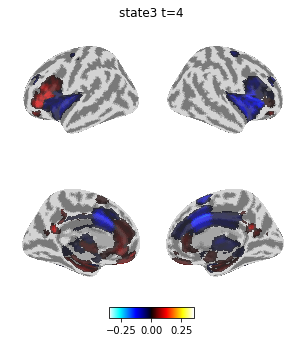

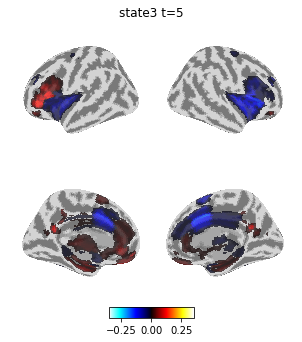

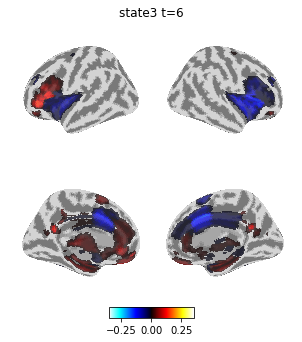

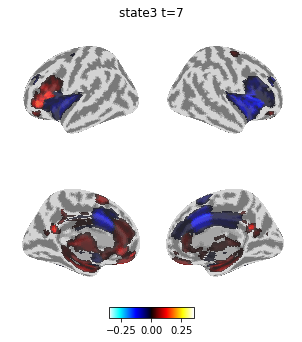

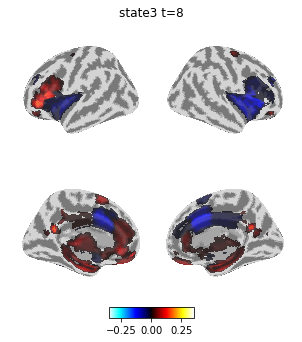

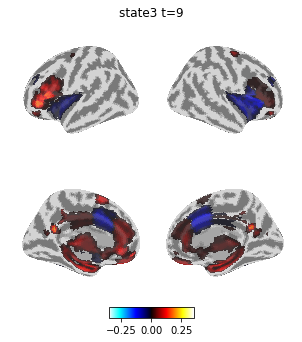

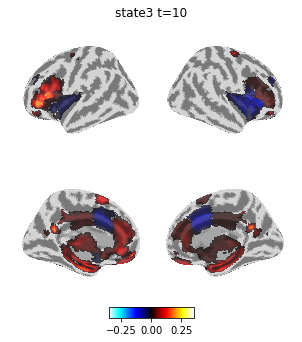

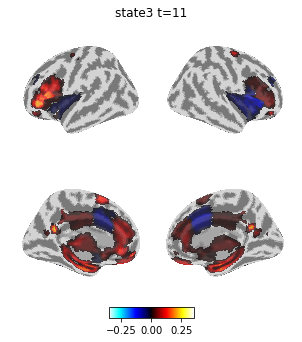

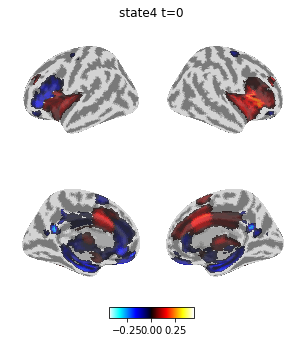

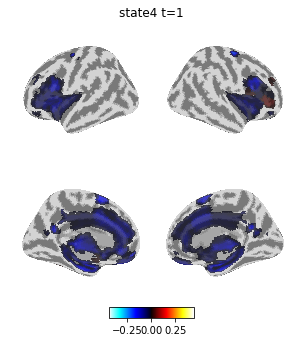

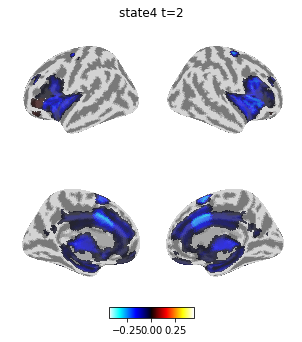

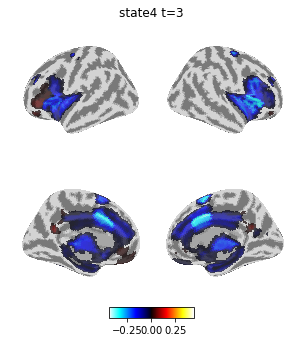

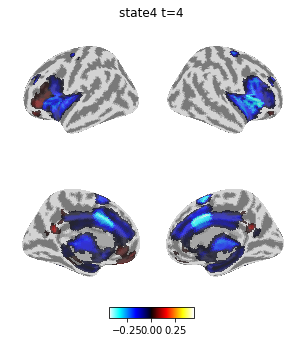

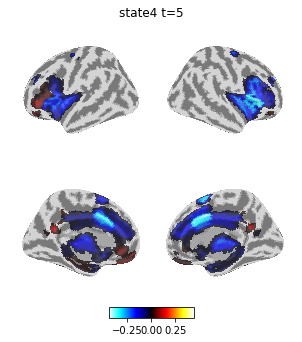

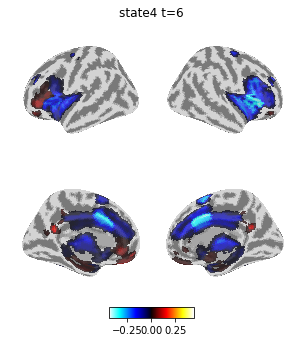

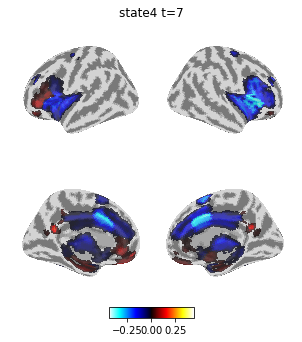

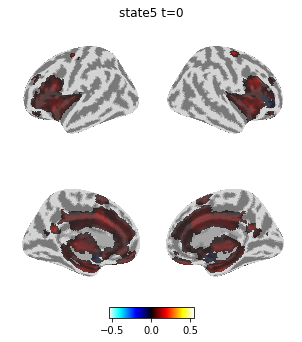

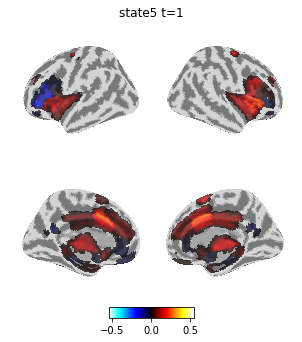

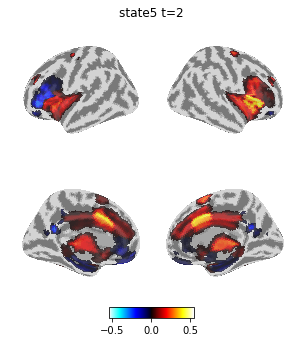

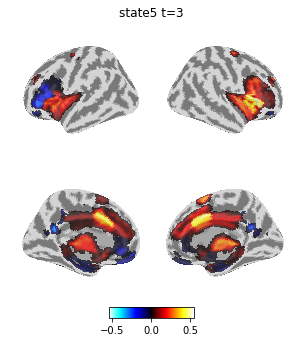

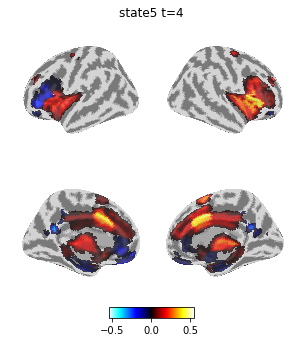

In [12]:
for idx_state in range(K-1):
    dur = int(np.median([y.shape[0] for y in state_resps[idx_state]]))
    mean_resps = ak.to_numpy(ak.mean(ak.Array(state_resps[idx_state]),axis=0))[:dur,:]
    
    print(mean_resps.shape)
    for t in range(mean_resps.shape[0]):
        img = vec2img(mean_resps[t,:])
        # plot_stat_map(img)
        fig,ax = plot_img_on_surf(
            stat_map=img,
            views=["lateral", "medial"],
            hemispheres=["left", "right"],
            colorbar=True,
            inflate=True,
            threshold=0.001,
            vmax=np.abs(mean_resps).max(),
            title=f'state{idx_state+1} t={t}',
            bg_on_data=True,
        )
        fig.savefig(f'./roi_importance/state{idx_state+1}_t={t+1}_bold.png',dpi=300,bbox_inches='tight',facecolor='white', transparent=False)